### The following is from [HERE](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html), then modified as the example is worked through

## Local Spatial Autocorrelation

Global measures of spatial auto correlation can help relate an observed pattern to a random process or some underlying signal.
* Identifying spatial auto correlation is useful for later statistical analysis:
    * It could indicate the relation of nearby locations to a signal or "spillover" from the outcomes at on site influence other sites
    * It could indicate "contagion" where outcomes at one site causally influence other sites
    * It could be the result of systematic spatial variation (heterogenitiy)
    * It could be the result of some previous data processing step, such as in downsampling where large patches of identical values could be created

No matter if the autocorrelation is due to substantive or neucance sources, it is a from of non-randomness that impacts statistical analysis.

Global measures of auto correlation are "whole-map" statistics, they are still important (allow to reduce a whole map to a single value), but fail to adapt on a local level to indicate where
* Eg., Moran's I does not indicate the areas of the map where specific types of values (highs or lows) are clustered or intanses of explicit dispersion. it tells us if they exist, not where.
 

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt     # Graphics
from matplotlib import colors
import seaborn as sns               # Graphics
import geopandas as gpd             # Spatial data manipulation
import pandas as pd                 # Tabular data manipulation
import rioxarray                    # Surface data manipulation
import xarray as xr                 # Surface data manipulation
from pysal.explore import esda      # Exploratory Spatial analytics
from pysal.lib import weights       # Spatial weights
import contextily                   # Background tiles

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


### Read in data

In [3]:
# EU Referendum data: https://web.archive.org/web/20170519102152if_/http://www.electoralcommission.org.uk:80/__data/assets/file/0014/212135/EU-referendum-result-data.csv

ref = pd.read_csv('./data/EU-referendum-result-data.csv')
ref

,id,Region_Code,Region,Area_Code,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,...,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
0,108,E12000006,East,E06000031,Peterborough,120892,87474,87469,72.35,87469,...,34176,53216,77,0,32,7,38,39.11,60.89,0.09
1,109,E12000006,East,E06000032,Luton,127612,84633,84636,66.31,84616,...,36708,47773,135,0,85,0,50,43.45,56.55,0.16
2,112,E12000006,East,E06000033,Southend-on-Sea,128856,93948,93939,72.90,93939,...,39348,54522,69,0,21,0,48,41.92,58.08,0.07
3,113,E12000006,East,E06000034,Thurrock,109897,79969,79954,72.75,79950,...,22151,57765,34,0,8,3,23,27.72,72.28,0.04
4,110,E12000006,East,E06000055,Bedford,119530,86136,86136,72.06,86135,...,41497,44569,69,0,26,1,42,48.22,51.78,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,65,E12000003,Yorkshire and The Humber,E08000032,Bradford,342817,228729,228729,66.72,228727,...,104575,123913,239,0,121,5,113,45.77,54.23,0.10
378,66,E12000003,Yorkshire and The Humber,E08000033,Calderdale,149195,106005,106008,71.05,106004,...,46950,58975,79,0,22,15,42,44.32,55.68,0.07
379,67,E12000003,Yorkshire and The Humber,E08000034,Kirklees,307081,217460,217449,70.80,217428,...,98485,118755,188,0,86,7,95,45.33,54.67,0.09
380,68,E12000003,Yorkshire and The Humber,E08000035,Leeds,543033,387730,387730,71.39,387677,...,194863,192474,340,39,116,8,177,50.31,49.69,0.09


In [3]:
#local administrative districts data: https://geoportal.statistics.gov.uk/datasets/7ecd281c3dfb42b6a5efeee2a68449b3/explore?location=46.568951%2C-20.834564%2C3.65

lads = gpd.read_file(
    './data/LAD_Dec_2016_GCB_in_the_UK_WGS84_2022_6459926952240361913.geojson')\
    .set_index("lad16cd")
lads

,OBJECTID,lad16nm,lad16nmw,bng_e,bng_n,long,lat,GlobalID,geometry
lad16cd,,,,,,,,,
E06000001,1,Hartlepool,,447157,531476,-1.27023,54.676159,93b45f2c-8102-4001-947d-86d43f2190d8,"MULTIPOLYGON (((-1.27024 54.72716, -1.26821 54..."
E06000002,2,Middlesbrough,,451141,516887,-1.21099,54.544670,305c44ba-9ea5-47b9-b5fe-c8c157838b7b,"MULTIPOLYGON (((-1.23001 54.58410, -1.23015 54..."
E06000003,3,Redcar and Cleveland,,464359,519597,-1.00611,54.567520,5ec566b7-571e-4508-9eee-527b6d9e907b,"MULTIPOLYGON (((-1.13717 54.64693, -1.13873 54..."
E06000004,4,Stockton-on-Tees,,444937,518183,-1.30669,54.556911,ed87565e-5370-4f59-af28-a54b37888c8a,"MULTIPOLYGON (((-1.31774 54.64524, -1.31713 54..."
E06000005,5,Darlington,,428029,515649,-1.56835,54.535351,0d06b63e-d4e0-45f0-98a4-500e25e1a72a,"POLYGON ((-1.63799 54.61719, -1.63766 54.61669..."
...,...,...,...,...,...,...,...,...,...
W06000020,387,Torfaen,Torfaen,327459,200480,-3.05101,51.698360,84d86f64-8f0d-471c-9936-c80cb2c71151,"POLYGON ((-3.10596 51.79548, -3.09636 51.79154..."
W06000021,388,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,ff5b2831-36b5-4e6b-a30e-d5586afbacc6,"MULTIPOLYGON (((-3.05214 51.97294, -3.05141 51..."
W06000022,389,Newport,Casnewydd,337897,187433,-2.89769,51.582321,69e9d2f8-66c8-4189-9dfa-5747c78585b6,"MULTIPOLYGON (((-2.83439 51.64824, -2.83452 51..."


#### Align the two datasets, ensuring indexes match, then join

In [4]:
# Set the index to Area_Code for the referendum results
ref.set_index("Area_Code", inplace=True)

# Ensure join keys are stripped of whitespace
ref.index = ref.index.str.strip()
lads.index = lads.index.str.strip()

In [5]:
# Check if the keys match
matching_keys = set(ref.index) & set(lads.index)
print(f"Number of matching keys: {len(matching_keys)}")

# Join the referendum data with the LAD boundaries
gdf = gpd.GeoDataFrame(
    lads.join(ref[["Pct_Leave"]]), crs=lads.crs
)

# Check if there are still NaNs
print(gdf["Pct_Leave"].isna().sum())


Number of matching keys: 380
11


In [6]:
gpd.GeoDataFrame(
         lads.join(ref[["Pct_Leave"]]), crs = lads.crs
      )

,OBJECTID,lad16nm,lad16nmw,bng_e,bng_n,long,lat,GlobalID,geometry,Pct_Leave
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,,447157,531476,-1.27023,54.676159,93b45f2c-8102-4001-947d-86d43f2190d8,"MULTIPOLYGON (((-1.27024 54.72716, -1.26821 54...",69.57
E06000002,2,Middlesbrough,,451141,516887,-1.21099,54.544670,305c44ba-9ea5-47b9-b5fe-c8c157838b7b,"MULTIPOLYGON (((-1.23001 54.58410, -1.23015 54...",65.48
E06000003,3,Redcar and Cleveland,,464359,519597,-1.00611,54.567520,5ec566b7-571e-4508-9eee-527b6d9e907b,"MULTIPOLYGON (((-1.13717 54.64693, -1.13873 54...",66.19
E06000004,4,Stockton-on-Tees,,444937,518183,-1.30669,54.556911,ed87565e-5370-4f59-af28-a54b37888c8a,"MULTIPOLYGON (((-1.31774 54.64524, -1.31713 54...",61.73
E06000005,5,Darlington,,428029,515649,-1.56835,54.535351,0d06b63e-d4e0-45f0-98a4-500e25e1a72a,"POLYGON ((-1.63799 54.61719, -1.63766 54.61669...",56.18
...,...,...,...,...,...,...,...,...,...,...
W06000020,387,Torfaen,Torfaen,327459,200480,-3.05101,51.698360,84d86f64-8f0d-471c-9936-c80cb2c71151,"POLYGON ((-3.10596 51.79548, -3.09636 51.79154...",59.78
W06000021,388,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,ff5b2831-36b5-4e6b-a30e-d5586afbacc6,"MULTIPOLYGON (((-3.05214 51.97294, -3.05141 51...",49.56
W06000022,389,Newport,Casnewydd,337897,187433,-2.89769,51.582321,69e9d2f8-66c8-4189-9dfa-5747c78585b6,"MULTIPOLYGON (((-2.83439 51.64824, -2.83452 51...",55.99


In [7]:
db = (
    gpd.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["OBJECTID", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000024
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


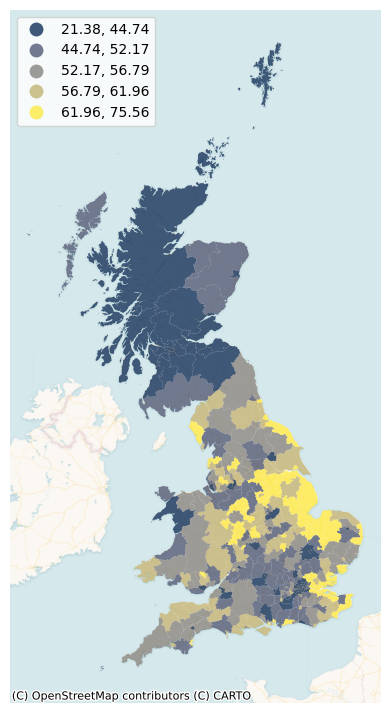

In [8]:
# Create a figure on a single axis
fig, ax = plt.subplots(1, figsize=(9,9))

# Create a cloropleth map
db.plot(
    column="Pct_Leave",
    cmap="cividis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax, 
)

# Add a basemap to show through these data
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)

# Remove axes labels (they show in meters or something)
ax.set_axis_off();

#### Generate spatial weights

We require spatial weighs for our statistic. There are a few ways we can do this. For this example we will use the eight nearest neighbors. Finally, we row standardize the weights.

In [9]:
# Generate weights W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db,k=8)

#row-standardization
w.transform = "R"

### Motivating local spatial autocorrelation

To best understand the undepinning concepts of local spatial autocorrelation we can examine it through the lens of Moran Plot (scatter). we will represent the data in a standardized form, as it is more intuitive and allows to more easily discern the topology of the spatial structure. 


In [10]:
#calculate the spatial lag from our variable of interest
db["w_Pct_Leave"] = weights.lag_spatial(w, db['Pct_Leave'])

# and the respective centered versions, where we display as a departure from the o'all mean
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["w_Pct_Leave_std"] = weights.lag_spatial(w, db['Pct_Leave_std'])

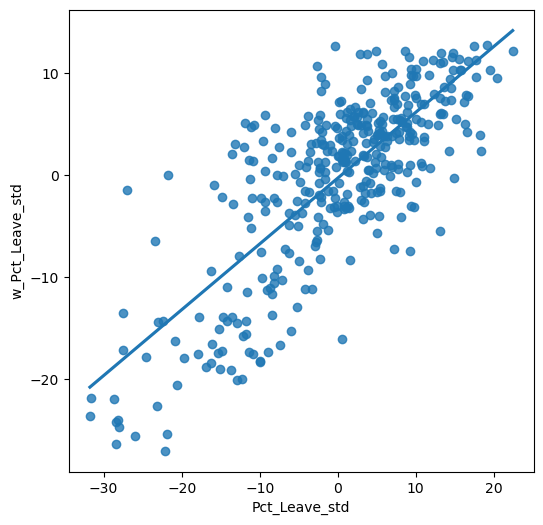

In [11]:
#set up axes and fig
fig, ax = plt.subplots(1, figsize=(6,6))

#plot the values
sns.regplot(x="Pct_Leave_std",
            y="w_Pct_Leave_std",
            data=db,
            ci=None,)
plt.show()

#### Visulize in quadrents

We see the above/below average voting vs the spatial lag.

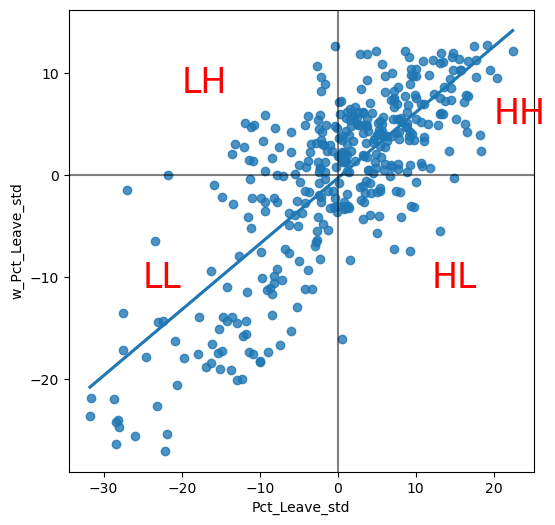

In [12]:
#set up axes and fig
fig, ax = plt.subplots(1, figsize=(6,6))

#plot the values
sns.regplot(x="Pct_Leave_std",
            y="w_Pct_Leave_std",
            data=db,
            ci=None,)
#add in our axis labels, quadrent lines, etc. 
plt.axvline(0,c="k", alpha=0.5)
plt.axhline(0,c="k", alpha=0.5)
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8, "LH", fontsize=25, c="r")
plt.text(-25, -11, "LL", fontsize=25, c="r")

plt.show()

### Local Moran's I

In the fogure above we have a classification of each observation relative to its neighbors, where every point is assigned a label. We are looking to identify areas of inusual concentrations of values. To know if a location belongs to a cluster that is statistically significant of a given kind we need to compare it to what we would expect if these data were distrobuted across the domain in a random manner; in other words we are interested in whether the strength with which the values are concentrates is unusually high - what LISAs are desogned to do. 

The core idea of local Moran's I is to identify cases in which the value of an observation ans the average of its sorroundings are either more similar (HH or LL), or dissimilar (LH, or HL), than by pure chance. How we accomplish this is simalar to global Moran's I, but applied in this case to each observation; resulting in as many statistics as there are original observations. 

The formal representation of the statistic can be written as:

$I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}$

where
is $m_2$ the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$
$w_{i,j}$,
is the spatial weight for the pair of observations
and $i$
$j$, and
$n$ is the number of observations.

LISAs are widely used in many fields ro identify geographical clusters of values or to find geographical outliers. They can return areas which values are concentrates and brovide some suggestive evidencs obout underlying processes. LISAs have been used in a wide array of applicaitons including: 
* Identification of geographical clusters of poverty [DSSC18](https://geographicdata.science/book/notebooks/references.html#id21)
* Ethnic enclaves [JPF10](https://geographicdata.science/book/notebooks/references.html#id38)
* Deliniate areas of high/low economic activity [TPPGTZ14](https://geographicdata.science/book/notebooks/references.html#id55)
* Identify clusters of contagious disease [ZRW+20](https://geographicdata.science/book/notebooks/references.html#id91)

In python, calculating a LISA is very streamlined thanks to [esda](https://pysal.org/esda/) - where we use the [Moran_Local](https://pysal.org/esda/generated/esda.Moran_Local.html#esda.Moran_Local) function

In [13]:
lisa = esda.moran.Moran_Local(db["Pct_Leave"], w)  #pass variable of interest and spatial weights

#### The LISA object

after we pass the variable of interest and the spatial weights, the LISA object contains several attributes of interest. 
* the local indicators are in the IS attribute
* other variables within the objject can be viewed with their descriptions [here](https://pysal.org/esda/generated/esda.Moran_Local.html#esda.Moran_Local)

We can get a sense of the local indicators by plotting them, in this case using seaborn's kernel density estimate (kde).

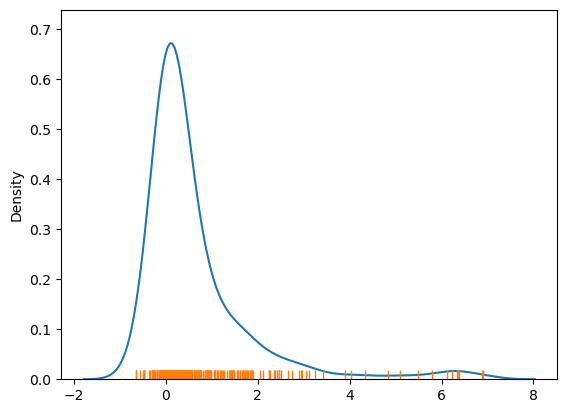

In [14]:
#draw the KDE line
ax = sns.kdeplot(lisa.Is)
#add a small bar (rug) for each observation along x axis
sns.rugplot(lisa.Is, ax=ax);

The skewed distribution of local Moran's I evident in the above figure is due to the domanace of positive forms of spatial auto correlation; implying most of the local statistic values will be positive. High I values arise from value similarity in space, this can be due to high values being next to high values or low values being next to low values. the local I values alone cannot distinguish between these two states. 

Due to the nature of LISAs, looking at the numerical result is not always the most useful way to exploit all of the informattion they can provide. Since we are calculating the statistic fo each observation it is difficult to extract a maningful pattern. In this context a cloropleth map can help. On first brush with the data it may seem that a colorpleth of the $I_i$ values would be a useful way to visulize, but this presents us with a probelem - we cannot distingish whether the association is positive (high-high) or negative (low-low) from this values alone. For example, in the context of these data, whether the blue areas in Scotland are similar to those in the eastern cluster os the blue areas (Are the two experiencing similar patterns of spatial association, or is one of them HH and the other LL?). Also, we know that values around zero will not be statistically significant. Which local statistics are thus *significant* and which ones *non-significant* from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones mere noise?

To answer these questions we need additional inforation that we computerd with the LISA statistic. This is done in 4 steps:

1) A straight forward cloropleth of the local statistic for each area
2) What quadrent each area is assigned to
3) Whether the statistic is considered *significant* or not
4) A combination of these two in a "cluster map"

A handy tool in this context is the splot library, part of the Pysal family, which provides a lightweight visualization layer for spatial statistics:

In [3]:
from splot import esda as esdaplot

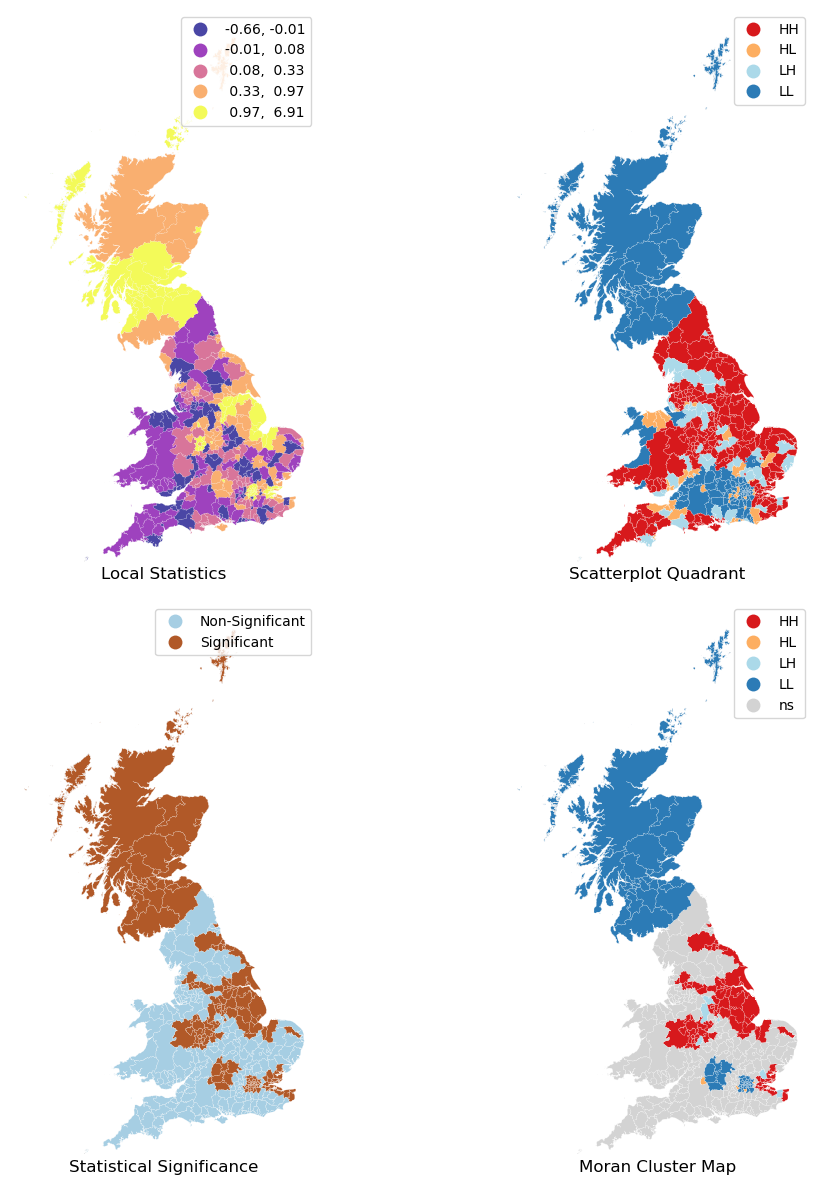

In [16]:
# Set up our figue and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
axes=axes.flatten() #make the axes assessible with single indexing

# First subplot
# Cloropleth fo Local statistics
# Grab first axis in the figure
ax = axes[0]
# Assign  new column with local statistics on-th-fly
db.assign(
    Is = lisa.Is,
    
    ).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
    )

# Subplot 2 
# Quadrant categories
# Grab second axis of local statistics
ax = axes[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3
# Significance map
# Grab our third subplot from the flattened axes
ax = axes[2]

# Find out our statistical observations
labels = pd.Series(
1 * (lisa.p_sim < 0.05), # assign 1 if significant, 0 otherwise
index=db.index,          # use the index of the original data
).map({1:"Significant", 0:"Non-Significant"}) #recode 1 to "Signifiacnt" and 0 to "Non-Significant"
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)

# Subplot 4
# cluster map
ax = axes[3]
# Plot quadrent colors in this case, we use 5% significance level
# to select polygons as part of statistically significant clusters

esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axes.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
fig.tight_layout()

# Display the figure
plt.show()

#### Interpreting the above maps

The map in the Upper left, with the purple and yellow velues display the largest absolute magnitude for the local statistics $I_i$. This specified positive spatial auto correlation, which can be correlation of sorrounding high or low values (HH or LL). this map cannot distinguish between areas with low support for the Brexit vote and those highly in favor. 

To distingusich between the in-favor and -not-in-favor areas, the map in the upper right shows the location (quadrant) of the LISA statistic in the Moran scatterplot. This indicates whether the positive (or negative) local association exists within a specific quadrant; this information is recorded within the q atribute of the lisa object.

In [17]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 4, 1, 1, 1, 1])

The corrspondance between the numbers in the q attribute and the actual quadrants are as follows: 
1) HH
2) LH
3) LL
4) HL

(in other words thes progress counter clockwise from the upper right quadrant as you learned in geometry)

In comparing the two maps we see that the top row (the first two axes) reveals thet the positive spatial local auto-correlation in Scotland in due to low support for brexit (high absolute statistic with values in the LL quadrant), whereas the positve local association in the south of England is amoung the local authorities that strongly support Brexit.

We can obtain the counts within each quadrant as follows:

In [18]:
counts = pd.value_counts(lisa.q)
counts

/tmp/ipykernel_245128/189452668.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(lisa.q)


1    181
3    112
2     51
4     36
Name: count, dtype: int64

This shows that the HH (1st quadrant) and LL (3rd quandant) values are predominant. We must excersise caution with the interpretation of the two maps, as the underlying statistical significance of the local values has yet to be considered. To this point we have simply mapped the raw LISA valus for each observation alingside the quandrant in which the local statistic resides. 

With regard to statistical significance, the bottom left map shows those polygons whose psedo-*p*-values is above (*"Non-significant"*) or below (*"Significant"*) to the threshold value of 5% we used in this context. An examination of the map suggests that quite a few locales have local statistics that are small enough so as to me comperable with pure chance.

Therefore, in order to focus on the areas that are most promising we need to include the significance information alongside the quadrent in which the local statitic resides. Together, this "cluster map" (as it is usually called) extracts the significance observations - those highly unlikely to have arisen due to pure chance - and plots theen with a specific color dependent on the quadrent category to which they belong (Significant LL values in one color, significant HH values in another color, and so on for the remaining quanrants). All of the needed informataion is contained within the lisa object we have created; if passed in tandem with the geo table containing the geographies they relate to then splot will create the cluster map for us (lower right map).

When reading the cluster map a few things become apperent that wiuld be difficult to grasp by looking at the other maps alone. These insighs arre arguabaly more relevant for the analysis of these data. First, fewer than half of the polygons have spatial auto correlation to such a dregree then to reject by pure chance: 

In [19]:
# calculate percent of polygons that are statistically significant
(lisa.p_sim < 0.05).sum() *100 / len(lisa.p_sim)

41.05263157894737

This reveals a bit over 40% of the local authoriteis are considered to be part of a spatial cluster via this analysis. 

Second, we identify three distinct areae of low support for leaving the EU: Scotland, London, Area sorrounding Oxford (NW of London).

Third, although there appeared to be many areas there the concentrated values indicating high support of Brexit, it is only the region in the NE and West of England whose spatial concentration shows enough strength to reasonabally rule out pure chance. 

Finally, let's explor exporting some of the significance and other information we plotted as well as a littl bit further dive into what these numbers represent - where it may be useful if we need to work with these valuse as part of a broader pipeline. 

So far, cluster maps have been handled by splot, but there is a lot that is happening under the hood. If we need to re-create one of these map, or to use this information in a different context, we would need to extract these data from our lisa object and link them back to the original db table. Here is how you could accomplish this. 

First, we pull the information captured within the lisa and insert it into the main data table:

In [20]:
# Assign the pseudo p-values to 'db'
db["p-sim"] = lisa.p_sim

# 1 if significant, (at 0.005 confidence level), otherwise 0
sig = 1 * (lisa.p_sim < 0.05)

# Assign the sig values as a "significance flag" variable to 'db'
db["sig"] = sig

# Print head of table to inspect the data
db[["sig","p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.010
E06000002,1,0.009
E06000003,1,0.014
E06000004,1,0.011
E06000005,1,0.006


In [21]:
# Print the bottom of the table to inspect
db[["sig","p-sim"]].tail()

,sig,p-sim
lad16cd,,
W06000020,0,0.479
W06000021,0,0.272
W06000022,0,0.346
W06000023,0,0.273
W06000024,0,0.299


From our inspection of the top 5 and botttom 5 valuse in the table, the top are statistically *Significant*, whereas the botom values are *Non-Significant*

Let's examine the sig column. Similar to global Moran's I, esda automatically computes a pseduo-*p*-value for each LISA. Because some instances of the LISA statistics may not be statistically significant, we will want to identify those eith *p*-values snall enough that we rule out the posibility of obtaining a similar value in random maps. A few different ways of generating random maps are considered by esda, but we will focus on a strategy that actually simulates hundereds of thousands of random maps to get a rough idea of the possible local statistic that could arise by random chance alone diven the input data. In addition we follow a similar reasoning as with global Moran's I and use 5% as the threshold fo statistical significance. To identify these values we create a "sig" value that contains "True" is the *p*-value of the observation satisfies the condition, otherwise "False".

Next we construct our quadrant values ising the q attrobute from the lisa object, which records the Moran Scatterplot quadrants for each local value. However, we now mask these values using the newly created binary significance map (contained in the variable sig), so only observations that are considered *Significant* are labeled as part of that quadrant; the remainder are labeled as *Non-Signifiacnt*

In [22]:
# Pick as part of a quadrant only significant polygons,
# assign 0 otherwise (Non-Significant polygons)
spots = lisa.q * sig

# Mapping from values to name of quadrant (as a dictionary)
spots_labels = { 
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}

#create a column in db with lables for each polygon
db["labels"] = pd.Series(
    spots,
    index=db.index,  # initilize a series using values and db index
).map(spots_labels)   #fill the labels mapping spots to the corresponding lable in the dictionary

# Print for inspection: 
db["labels"].head()

lad16cd
E06000001    HH
E06000002    HH
E06000003    HH
E06000004    HH
E06000005    HH
Name: labels, dtype: object

These clusters are meaningful if you have an intuition of what the Moran Plot looks like, to help make them a bit more intuitive, a terminology that is sometimes used goes as follows. Positive forms of local spatial autocorrelation are of two types. First, HH observations, which we can term as “hot spots”, represent areas where values at the site and its surroundings are larger than average. Second, LL observations, significant clusters of low values surrounded by low values, are sometimes referred to as “cold spots”. Negative forms of local spatial autocorrelation also include two cases. When the focal observation displays low values but its surroundings have high values (LH), we call them “doughnuts”. Conversely, areas with high values but neighbored by others with low values (HL) can be referred to as “diamonds in the rough”. We note this terminology is purely mnemonic, but recognize in some cases it can help in remembering the interpretation of local statistics.

After building these new columns for the db, analysis on the overall trense of LSA statistics is more straightforward thean pulling from the lisa object. for example, and overview of the distribution of the lables is a one-liner:

In [23]:
db["labels"].value_counts()

labels
Non-Significant    224
HH                  75
LL                  71
LH                   6
HL                   4
Name: count, dtype: int64

This indicates that most locales are *not* statistically significant. Among those that are, we saw many more hotspots/coldspots than doughnuts/diamons-in-the-rough. This is consistent with ths skew of the distribution in the local statistic we saw earlier. 

### Getis and Ord's local statistics

As with the global icase there are mre indicators of local spatial auto correlation than Moran's . esda includes Getis and Ord's $G_i$ statistics. These are a different kind of local statistic that are commonly used in two forms the $G_i$ statistic, which omits the calue at a si in its local summary, and the $G_i^*$, which includes the site's own value  in the local summary. The process to calculate them follows a similar pattern as with Local Morans $I_i$ statistic above. 

Let's see how it would look to calculate $G_i$ and $G_i^*$ for our Brexit example:

In [24]:
# Gi
go_i = esda.getisord.G_Local(db["Pct_Leave"], w)

# Gi*
go_i_star = esda.getisord.G_Local(db["Pct_Leave"], w, star=True)

/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/esda/getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


Unlike with LISAs, [splot](https://splot.readthedocs.io/en/latest/esda.html) does not support visulization of G statistics at this point. In order to visulize their output we will instead write a function that generates the map from the statistic's output object and its set of associated geometries. 

In [25]:
def g_map(g, db, ax):
    """
    Create a Cluster Map for G statistics
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """

    ec = "0.8" #edgecolor
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    nsig = db.loc[sig == False, "geometry"]
    nsig.plot(ax=ax, color="lightgray", edgecolor=ec, linewidth=0.1)

    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)

    # Plot ll clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)

    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source = contextily.providers.Esri.WorldTerrain,
    )

    # Flag to add a star to the title if it is G_i* statistic being plotted
    st = ""
    if g.star:
        st = "*"

    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size = 15)

    #remove axis labels for aesthetics
    ax.set_axis_off()
    return ax

With access to this plotting finction, generating $G_i^{(*)}$ cluster maps is as straight forward as it is for LISA outputs through splot in the prior figs

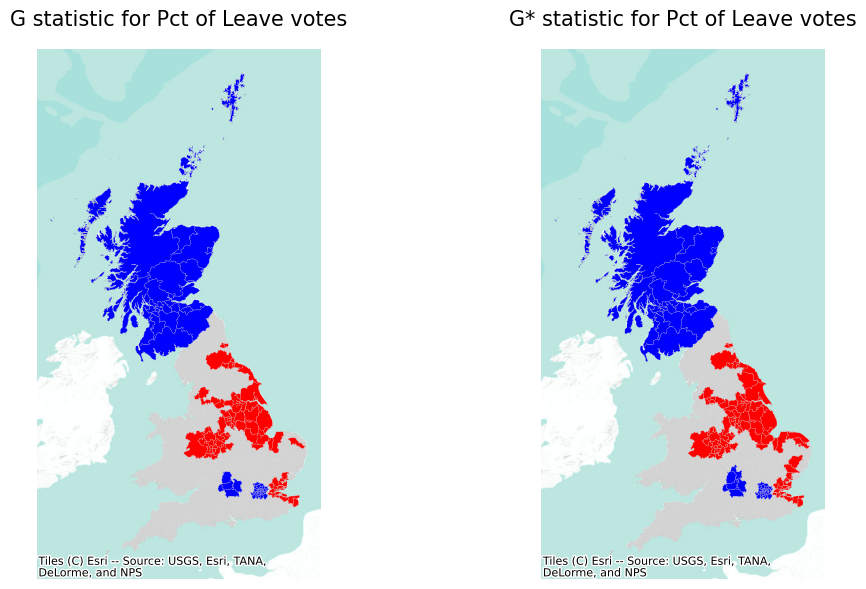

In [26]:
# Set up the figure and axes
fig, axes = plt.subplots(1,2, figsize = (12,6))

# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axes.flatten()):
    ax = g_map(g, db, ax)  #generate the statistic map

# Apply the tight layout to minimize the blank spaces
fig.tight_layout()

plt.show()

I this case there is virtually no difference between the two plots for $G_i$ and $G_i^*$. Also, at first glance the maps seem to be visually similar to the final LISA map from above. Naturally, this leads to the question *then why use the $G_i$ statistics at all?* Toa answer to this wuestion is that the two sets of local statistics - local $I$ and local $G_i$, are complementary statistics. The local $I_i$ statistic gives an indication fo cluster/outlier status, whereas thelocal $G_i$ shows which side of the hotspots/coldspots divide the observation is on. Alternativly, the Local Morna's $I_i$  clustermap provides both pieces of information, but can be more challenging to viulize all at once. **As such, it depends on your analytical preferences and the point of the analysis at hand.** 

### Local statistics on surfaces

Conceptually, computing LISAs across a raster surface is very simmilar to that of computing them from a geotable. The computation of Moran's I over data stored as a surface allows for a broader array of input data to be used - a format increasingly common for data dissemination - albeit this computation has a few quirks as the tools are not as fully developed. 

The use of LISAs on surfaces is still experimental and can be a little rough around the edges. Unlike Geo-tables, surfaces have not been a common usecase for geographic data scientists and the tooling ecosystem is not as evolved. Nonetheless, the ability to compute LISAs over surfaces does exist as a set of building blocks to develop a full fledged ecosystem for more sophisticated analysis. 

We will be using population data of Sao Paulo, Brazil for this initial analysis. In the Build_GHSL_Extract.ipynb we will extract these data.

Data originally used in the tutorial are avalible [HERE](https://geographicdata.science/book/data/ghsl/build_ghsl_extract.html) and [HERE](https://geographicdata.science/book/data/ghsl/build_ghsl_extract.html) with updated data avalible [HERE](https://human-settlement.emergency.copernicus.eu/ghs_pop2023.php)

In [49]:
# Open GeoTIFF file and read in populaiton data via rioxarray into an xarray DataArray
#pop = rioxarray.open_rasterio("./data/ghsl_sao_paulo_1000m_2020.tif")
#pop = rioxarray.open_rasterio("./data/ghsl_barcelona.tif")
pop = xr.open_dataset("/media/skye/LEAKE_250gb1/EAE790_Spring24/EOC8p5/DIST_WRFEOC8p5_99-100_WetPeriod_0p254base_15minPeriodCount_for_Annual.nc",
                     engine="netcdf4")

In [50]:
pop = pop.PRECIP_PERIOD.mean(dim='Time')
pop

<xarray.DataArray 'PRECIP_PERIOD' (south_north: 899, west_east: 1399)> Size: 10MB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 32.86666667,
        28.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 28.06666667,
        22.66666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    lat      (south_north, west_east) float32 5MB ...
    lon      (south_north, west_east) float32 5MB ...
Dimensions without coordinates: south_north, west_east

In [51]:
print(pop.lon.values)


[[-121.81102  -121.77783  -121.74463  ...  -73.25537   -73.22217
   -73.188965]
 [-121.81999  -121.786804 -121.7536   ...  -73.2464    -73.213196
   -73.17999 ]
 [-121.82898  -121.79578  -121.76254  ...  -73.23746   -73.20422
   -73.17102 ]
 ...
 [-133.62482  -133.57828  -133.53171  ...  -61.468292  -61.421722
   -61.375183]
 [-133.64409  -133.59752  -133.55093  ...  -61.449066  -61.402466
   -61.355927]
 [-133.66338  -133.61679  -133.57019  ...  -61.42981   -61.38321
   -61.33661 ]]


In [55]:
min_lon = -105.00
max_lon = -90.00
min_lat = 30.00
max_lat = 45.00

subset = pop.where(
    (pop.lat >= min_lat) & (pop.lat <= max_lat) &
    (pop.lon >= min_lon) & (pop.lon <= max_lon),
    drop=True
)

# Check the shape of the subset
print(subset.shape)

(452, 389)


In [56]:
type(pop)

xarray.core.dataarray.DataArray

In [57]:
pop

<xarray.DataArray 'PRECIP_PERIOD' (south_north: 899, west_east: 1399)> Size: 10MB
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 32.86666667,
        28.33333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 28.06666667,
        22.66666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
    lat      (south_north, west_east) float32 5MB 20.51 20.52 ... 48.91 48.89
    lon      (south_north, west_east) float32 5MB -121.8 -121.8 ... -61.34
Dimensions without coordinates: south_north, west_east

Next we build the weights matrix that represents the spatial configuration of the pixels with the values in pop. In this case we will use a differnt approach than KNN, although the results are broadly similar. There is more info if we follow the notebook covering weights.

In [11]:
w_surface_sp = weights.Queen.from_xarray(pop)

Now, the first hairy bit. Weights from the weight builder for surfaces are expressed as an integer, we need then as floats so that when multiplication happens further down the pipeline we get the decimals and not a truncated value. Second, we need the W object, as it stands we have WSP:

In [23]:
type(w_surface_sp)

libpysal.weights.weights.WSP

WSP objects (weights sparse) are a tin version of the weights matricies optimized for certian computations and are more lightweight in terms of memory requirements (They are great, for say, spatial econometrics). Unfortunately, to calculate LISA statistics, we require greater level of detail, so we need to convert into a W object. 

In [24]:
# Building from low-level: convert sparse matrix to floats, build the WSP object, convert from WSP to W
w_surface_all = weights.WSP2W(
    weights.WSP(
        w_surface_sp.sparse.astype(float), id_order=w_surface_sp.index.tolist()
        )
    )

w_surface_all.index = w_surface_sp.index  # Assign index to new W

This leaves us with a weights object (w_surface) we can work with for the LISA. Next is to recast the values from the original data structure to one that Moran_Local will understand. This happens in the next code snippet:

In [25]:
# Convert DataArray to a Pandas series
pop_values = pop.to_series()

# Subset to keep only values that aren't missing
pop_values = pop_values[pop_values != pop.rio.nodata]


We performed two operations in the above. converting to a series and using the no_data value of the raster surface to filter out those instances in which we do not have data. As theis is a GeoTiff raster surface the no_data value isn't commonly a NaN, rather an impossibly rare value, the maximum value for a range (i.e. 9999), or a negative value if the data can only be positive (i.e., -1; -255). We can see the no_data attribute of the raster like so:

In [26]:
pop.rio.nodata

One final step: out w_surface_all contains a row and column for every pixel in pop, including those without a value (i.e., those with no_data). We need to subset it to align it with pop values:

In [27]:
w_surface = weights.w_subset(w_surface_all, pop_values.index)
w_surface.index = pop_values.index

At this point, we are ready to run a LISA the same way we have done in the previous chapter when using geo-tables, additional information in [ANS1995](https://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1995.tb00338.x):

In [ ]:
#NOTE: this may take a while longer to run depending on the hardware, 5 minutes on an 8 core laptop, ~16 gb of ram
pop_lisa = esda.moran.Moran_Local(
     pop_values.astype(float), w_surface, n_jobs = -1
    )   #using row standardization (default), n_jobs = -1 is for using all cores in conditional randomization

Note that we explicitly cast the populaiton values as floats before computing the LISA to ensue they are in line with our spatial weights. 

#### Surface local autocorrelation visulization

Now that the LISA has been computed it is on to the visulization. For this we need to express the results as a surface rather than that of a table, for which we will use the converstion bridge built into pysal:

In [26]:
from libpysal.weights import raster

Our aim is to create a cluster map in a like manner to the tabular examples above. This means we need to filter by those with statistical sugnificans andd color ccode based on the quadrant off the moran plot to which they belong. 

For this, we will creeate a new Series that intersects the quandrant information with significance. For this example we will use the 1% confidance level:

In [27]:
sig_pop = pd.Series(
     pop_lisa.q * (pop_lisa.p_sim < 0.01),  # Quadrant of significance at 1%, (0 otherwise)
     index=pop_values.index,
    )

The sig_pop opbject, expressed here as a 1D vector, contains the information we would like to recast to an Xarrary DataArray object. For this conversion we can use the w2da finction in libpysal.weights, which derives the spatial configuration of each value in sig_pop from w_surface. 

In [28]:
# Build DataArray from a set of values and weights
lisa_da = raster.w2da(
     sig_pop,    # Values
     w_surface,  # Weights
     attrs={
         "nodatavals":[pop.rio.nodata]
     }  # Value for missing data
    ).rio.write_crs(pop.rio.crs)  # Add CRS information in a compliant manner

The resulting DataArray only contains:
* Missing data pixels (expressed with the same negative value as the original pop featue's no_data)
* 0 for non significant pixeos
* 1-4 depending on quadrant of HH, LH, LL, HL respectivly

In [29]:
lisa_da.to_series().value_counts()

-200    6091
 0      3808
 3      1364
 1       879
 2        25
 4         1
Name: count, dtype: int64

In [30]:
type(lisa_da)

xarray.core.dataarray.DataArray

We have all the data in the correct shape to build the figure, but before we do that we need a dictionary of colors to map to the various categories. (Before this was handled for us by splot we called these in the plotting function in the case of $G_i^{(*)}$ cluster maps). For surfaces we are not as lucky to have this task covered by other functions. 

First we create the colormap to encode clusters with the same colors splot uses of geotables. For that we need the method in matplotlib that builds colormaps from a list of colors. 

In [31]:
from matplotlib.colors import ListedColormap

# LISA colors
lc = {
    "ns": "lightgray",# Values of 0
    "HH": "#d7191c",  # Values of 1
    "LH": "#abd9e9",  # Values of 2
    "LL": "#2c7bb6",  # Values of 3
    "HL": "#fdae61",  # Values of 4
    }

With these pieces, we can create the colormap object that replicates our original local Moran cluster map colors. 

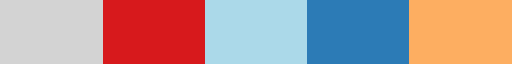

In [32]:
lisa_cmap = ListedColormap(
    [lc["ns"], lc["HH"], lc["LH"], lc["LL"], lc["HL"]]
)
lisa_cmap

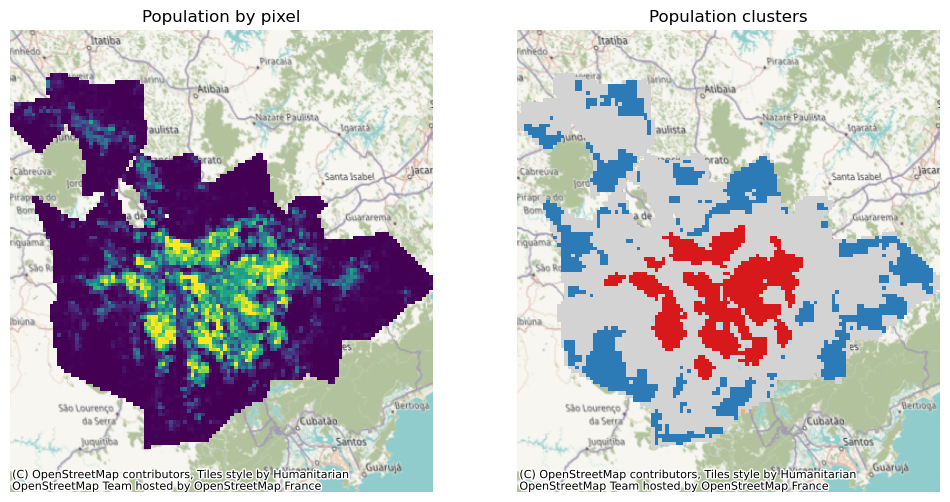

In [33]:
###### Set up figure and axes
fig, axes = plt.subplots(1,2, figsize=(12,6))
# Subplot 1
# Select pixels that do not have the 'nodata' value (where they are missing data)
pop.where(
    pop != pop.rio.nodata
    ).plot(
        ax=axes[0],
        add_colorbar=False, # , cbar_kwargs={"orientation": "horizontal"}
        robust=True,
    )

# Subplot 2
# Select pixels with no missing data and rescale to [0,1] by dividing by 4 
#     (4 is max value in lisa_da)
(
    lisa_da.where(lisa_da != -200) /4
).plot(
    cmap=lisa_cmap,
    ax=axes[1],
    add_colorbar=False,
    )

# Aesthetics
# Subplot titles
titles = ["Population by pixel", "Population clusters"]
# Apply the following to each of the two subplots
for i in range(2):
    # Keep proportion of axes
    axes[i].axis("equal")
    # Remove axis
    axes[i].set_axis_off()
    # Add title
    axes[i].set_title(titles[i])
    # Add basemap
    contextily.add_basemap(axes[i], crs=lisa_da.rio.crs)


Now we want to look at population departues for an urbn area. We will use Sao Palo 1990 and 2020 populaiton data for this

In [2]:
# Open GeoTIFF file and read in populaiton data via rioxarray into an xarray DataArray
pop_2000 = rioxarray.open_rasterio("./data/ghsl_sao_paulo_1000m_2000.tif")
pop_2020 = rioxarray.open_rasterio("./data/ghsl_sao_paulo_1000m_2020.tif")

For now we will need to change the no_value representation. -200 will easily become a valid value if we work in absolute terms or in percentage. A number that is substantially and obviousally out of range is required; np.nan will NOT work in this case.


In [3]:
no_data_val = -20000

In [4]:
pop_2000 = pop_2000.where(pop_2000 != -200, no_data_val) # Convert our -200 to a different nodata value
pop_2000 = pop_2000.where(pop_2000 != 0 , no_data_val)   # Where data is equal to 0, add to nodata to avoid div by 0 errors
pop_2000.rio.write_nodata(no_data_val, inplace=True)     # Update the value expressing nodata in the rioxarray data array
pop_2000.rio.nodata

-20000.0

In [5]:
pop_2000

<xarray.DataArray (band: 1, y: 104, x: 117)> Size: 97kB
array([[[-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        ...,
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 936B -4.482e+06 -4.48e+06 ... -4.366e+06 -4.366e+06
  * y            (y) float64 832B -2.822e+06 -2.824e+06 ... -2.926e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -20000.0
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
pop_2020 = pop_2020.where(pop_2020 != -200 , no_data_val)  # Convert our -200 to a different nodata value
pop_2020 = pop_2020.where(pop_2020 != 0 , no_data_val)     # Where data is equal to 0, add to nodata to avoid div by 0 errors
pop_2020.rio.write_nodata(no_data_val, inplace=True)       # Update the value expressing nodata in the rioxarray data array
pop_2020.rio.nodata

-20000.0

In [7]:
pop_2020

<xarray.DataArray (band: 1, y: 104, x: 117)> Size: 97kB
array([[[-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        ...,
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 936B -4.482e+06 -4.48e+06 ... -4.366e+06 -4.366e+06
  * y            (y) float64 832B -2.822e+06 -2.824e+06 ... -2.926e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -20000.0
    scale_factor:   1.0
    add_offset:     0.0

In [8]:
xr.align(pop_2000, pop_2020, join='exact')  # we have coordinates as float, to be safe and avoid errors we need to check of the coordinates aligh

#where no data is not true, return 2020-2000, else return the no data value 
pop_diff = xr.where(pop_2020 != pop_2020.rio.nodata, pop_2020-pop_2000, pop_2020.rio.nodata)

#eps = np.finfo(np.float32).eps  # an epsilon to avoid 0/#value = inf 
#where no data is not true, return percent change of 2020-2000 relative to 2000, else return the no data value 

pop_diff_per = xr.where(pop_2020 != pop_2020.rio.nodata, ((pop_2020 - pop_2000)/pop_2000)*100, pop_2020.rio.nodata)

pop_diff.rio.write_crs(pop_2020.rio.crs, inplace=True) # re-assign the coordinate reference system data since xarray.where nuked it
pop_diff_per.rio.write_crs(pop_2020.rio.crs, inplace=True) # re-assign the coordinate reference system data since xarray.where nuked it


<xarray.DataArray (band: 1, y: 104, x: 117)> Size: 97kB
array([[[-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        ...,
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 936B -4.482e+06 -4.48e+06 ... -4.366e+06 -4.366e+06
  * y            (y) float64 832B -2.822e+06 -2.824e+06 ... -2.926e+06
    spatial_ref  int64 8B 0

In [9]:
pop_diff.rio.write_nodata(no_data_val, inplace=True)
pop_diff.rio.nodata

-20000.0

In [10]:
pop_diff_per.rio.write_nodata(no_data_val, inplace=True)
pop_diff_per.rio.nodata

-20000.0

In [11]:
pop_var = pop_diff_per

In [12]:
pop_var.mean()

<xarray.DataArray ()> Size: 8B
array(-10619.70857527)
Coordinates:
    spatial_ref  int64 8B 0

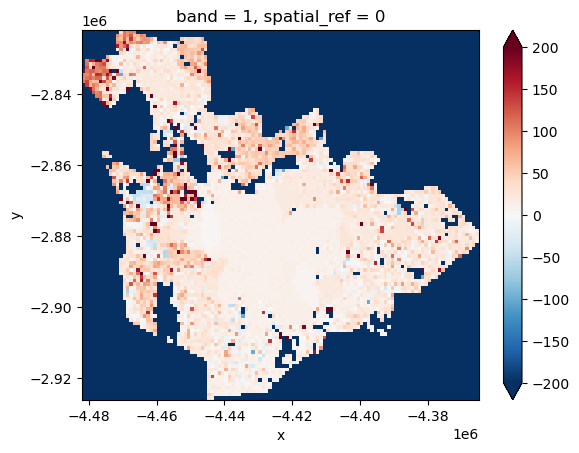

In [13]:
pop_var.plot(vmin = -200)

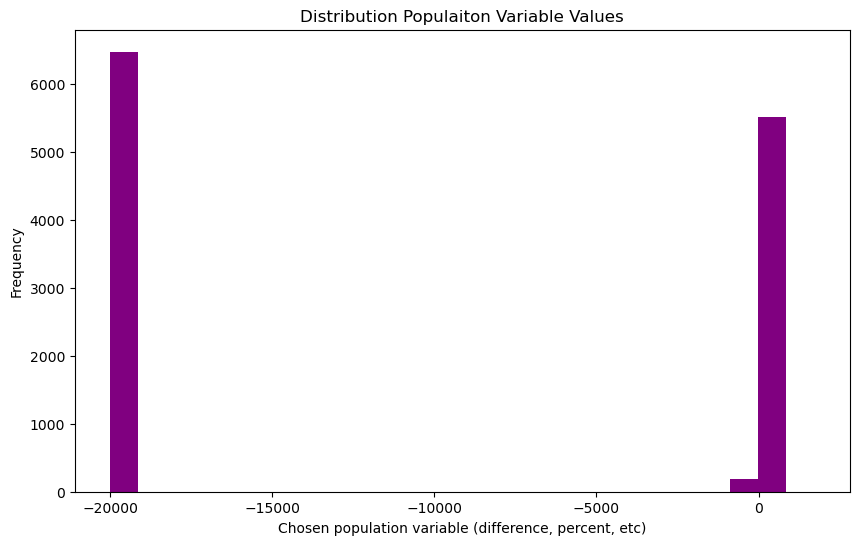

In [14]:
# Plot a histogram to check if values are within the range we expect - a bunch of no values and valid data values
f, ax = plt.subplots(figsize=(10, 6))
pop_var.plot.hist(ax=ax,
       color="purple",
       bins=25,
       )
ax.set(title="Distribution Populaiton Variable Values",
       xlabel='Chosen population variable (difference, percent, etc)',
       ylabel='Frequency')
plt.show()


In [15]:
import datashader as ds
cvs = ds.Canvas(plot_width=600, plot_height=600)
agg = cvs.raster(pop_var.where(pop_var != pop_var.rio.nodata).sel(band=1))
#agg = cvs.raster(pop_diff_per.sel(band=1))

/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


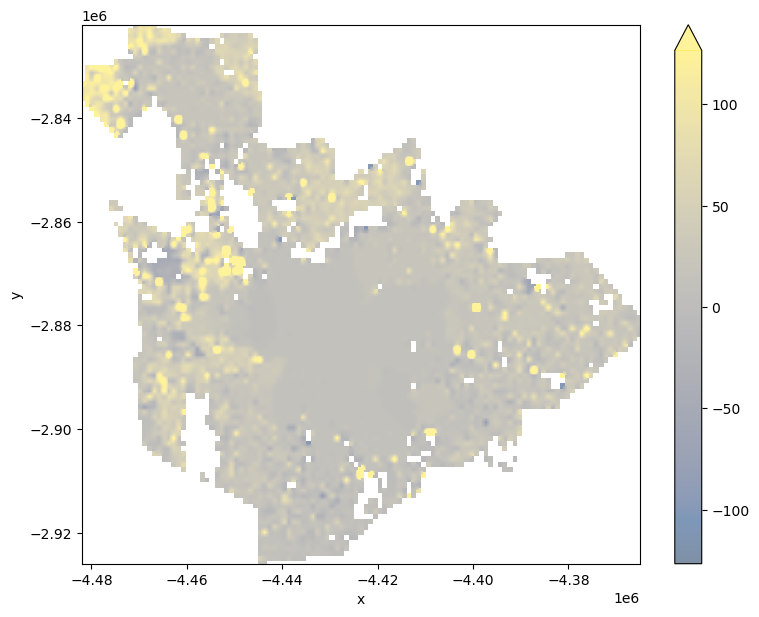

In [16]:
fig, ax = plt.subplots(1, figsize=(9,7))
agg.plot.imshow(ax=ax, alpha=0.5, cmap="cividis", robust=True)

In [17]:
w_surface_la = weights.Queen.from_xarray(pop_var)

# Building from low-level: convert sparse matrix to floats, build the WSP object, convert from WSP to W
w_surface_all = weights.WSP2W(
    weights.WSP(
        w_surface_la.sparse.astype(float), id_order=w_surface_la.index.tolist()
        )
    )

w_surface_all.index = w_surface_la.index  # Assign index to new W

In [18]:
# Convert DataArray to a Pandas series
pop_values = pop_var.to_series()

# Subset to keep only values that aren't missing (pull no data property from the data array)
pop_values = pop_values[pop_values != pop_var.rio.nodata]


In [19]:
w_surface = weights.w_subset(w_surface_all, pop_values.index)
w_surface.index = pop_values.index

/home/skye/miniconda3/envs/Spatial_stats/lib/python3.11/site-packages/libpysal/weights/set_operations.py:386: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: (1, -2905500.0, -4391500.0).
  return W(neighbors, id_order=list(ids), **kwargs)


In [20]:
#NOTE: this may take a while longer to run depending on the hardware,
#      5 minutes on an 8 core laptop, ~16 gb of ram for 100m Sao Paulo data
pop_lisa = esda.moran.Moran_Local(
     pop_values.astype(float), w_surface, n_jobs = -1
    )   #using row standardization (default), n_jobs = -1 is for using all cores in conditional randomization

('WARNING: ', (1, -2905500.0, -4391500.0), ' is an island (no neighbors)')


In [21]:
from libpysal.weights import raster

sig_pop = pd.Series(
     pop_lisa.q * (pop_lisa.p_sim < 0.01),  # Quadrant of significance at 1%, (0 otherwise)
     index=pop_values.index,
    )

In [22]:
# Build DataArray from a set of values and weights
lisa_da = raster.w2da(
     sig_pop,    # Values
     w_surface,  # Weights
     attrs={
         "nodatavals":[pop_var.rio.nodata]
     }  # Value for missing data
    ).rio.write_crs(pop_var.rio.crs)  # Add CRS information in a compliant manner

In [23]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib.collections import QuadMesh
from matplotlib.colorbar import Colorbar

def add_custom_legend(ax_or_quadmesh, cmap, labels, legend_kwargs=None):
    """
    Adds a custom legend to a quad mesh plot.
    
    Parameters:
    ax_or_quadmesh : matplotlib.axes.Axes or matplotlib.collections.QuadMesh
        The axis or QuadMesh to which the legend should be added.
    cmap : matplotlib.colors.ListedColormap
        The custom colormap to use.
    labels : list of str
        The ordered list of labels corresponding to the colormap.
    legend_kwargs : dict, optional
        Additional keyword arguments to be passed to the legend.
    
    Returns:
    ax : matplotlib.axes.Axes
        The axis with the legend applied.
    """
    # If legend_kwargs is not provided, initialize it as an empty dictionary
    if legend_kwargs is None:
        legend_kwargs = {}
    
    # If a QuadMesh object is provided, get its axis
    if isinstance(ax_or_quadmesh, QuadMesh):
        ax = ax_or_quadmesh.axes
    else:
        ax = ax_or_quadmesh
    
    # Create custom legend patches
    legend_patches = [mpatches.Patch(color=cmap.colors[i], label=label) 
                      for i, label in enumerate(labels)]
    
    # Add the custom legend to the plot
    legend = ax.legend(handles=legend_patches, **legend_kwargs)
    
    # Set edgecolor and linewidth for each patch in the legend manually
    for patch in legend.legendHandles:
        patch.set_edgecolor('black')
        patch.set_linewidth(1.5)
    
    return ax

In [24]:
lisa_da.to_series().value_counts()

-20000    6469
 0        5490
 3         114
 1          45
 2          31
 4          19
Name: count, dtype: int64

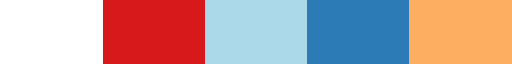

In [25]:
from matplotlib.colors import ListedColormap

# LISA colors
lc = {
    "ns": (1.0, 1.0, 1.0, 0.0),  # Fully transparent
    "HH": (215/255, 25/255, 28/255, 1.0),    # Values of 1
    "LH": (171/255, 217/255, 233/255, 1.0),  # Values of 2
    "LL": (44/255, 123/255, 182/255, 1.0),   # Values of 3
    "HL": (253/255, 174/255, 97/255, 1.0),   # Values of 4
}

lisa_cmap = ListedColormap(
    [lc["ns"], lc["HH"], lc["LH"], lc["LL"], lc["HL"]]
)
lisa_cmap

In [26]:
pop_var

<xarray.DataArray (band: 1, y: 104, x: 117)> Size: 97kB
array([[[-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        ...,
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.],
        [-20000., -20000., -20000., ..., -20000., -20000., -20000.]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 936B -4.482e+06 -4.48e+06 ... -4.366e+06 -4.366e+06
  * y            (y) float64 832B -2.822e+06 -2.824e+06 ... -2.926e+06
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:  -20000.0

/tmp/ipykernel_341861/3728393200.py:43: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for patch in legend.legendHandles:


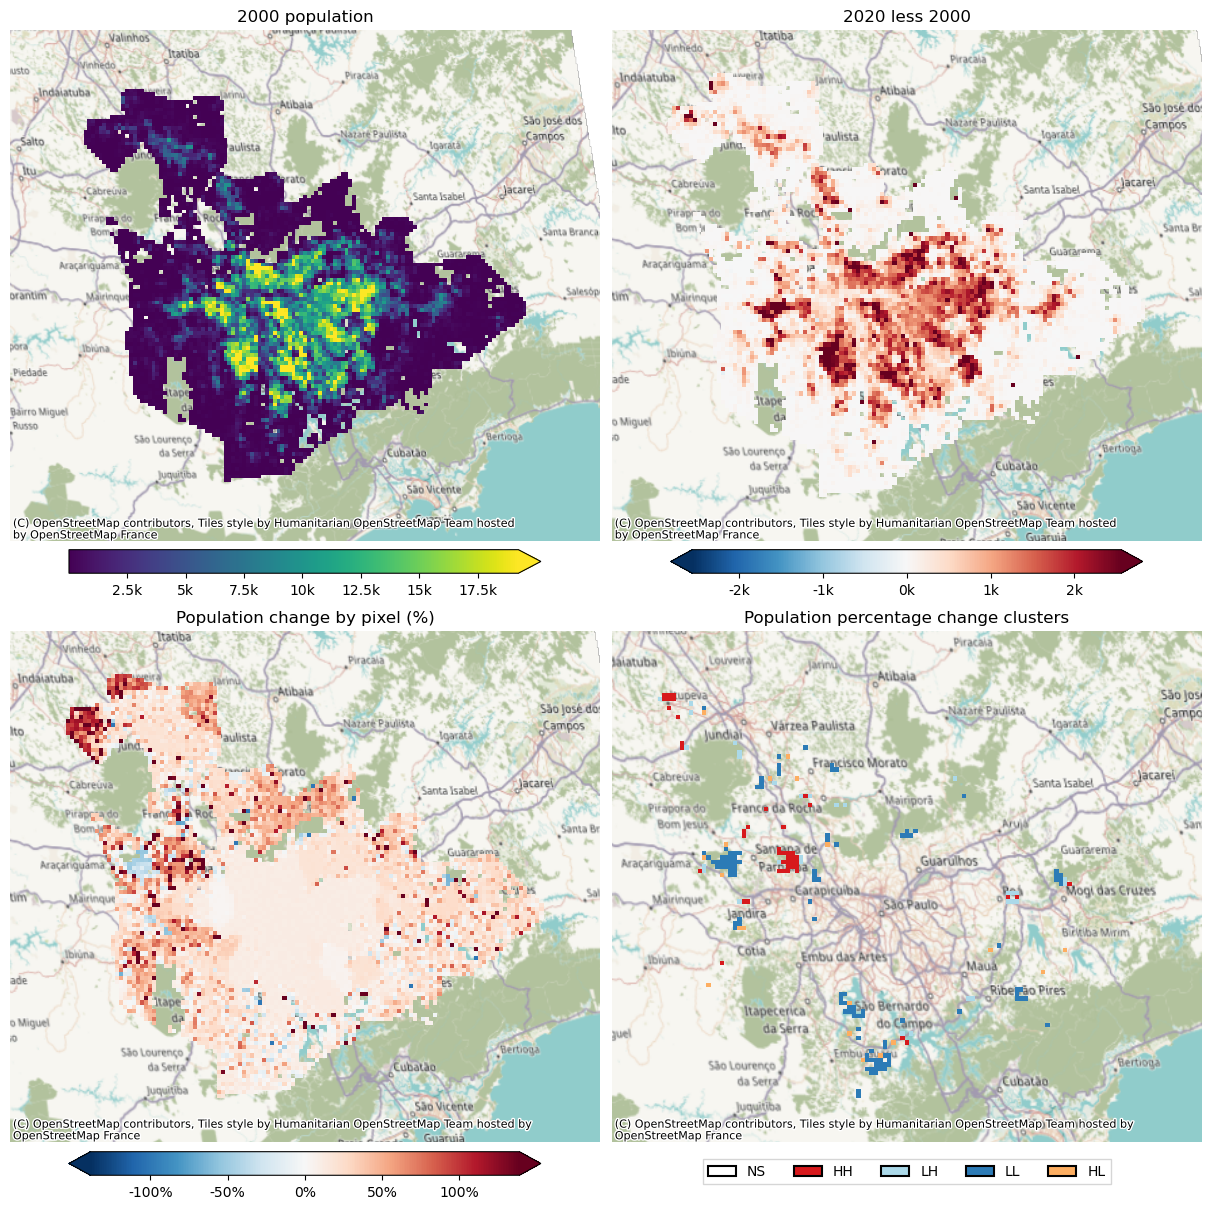

In [31]:
###### Set up figure and axes
fig, axes = plt.subplots(2,2, figsize=(12,12), layout="constrained", subplot_kw={'aspect': 1})
axes = axes.flatten()

# define our function to be used to format the tick labels 
kfmt0 = lambda x, pos: "{:g}k".format(x / 1000)
kfmt2 = lambda x, pos: "{:g}%".format(x)

#cb = fig.colorbar(p, ax=ax, format=kfmt)


# Subplot 1
pop_2000.where(
    pop_2000 != pop_2000.rio.nodata
    ).plot(
        ax=axes[0],
        add_colorbar=True , cbar_kwargs={"orientation": "horizontal", "shrink":0.8, "format":kfmt0, "extend":"max", "pad":0.02},
        robust=True,
        #alpha = 0.5,
    )

# Subplot 2
pop_diff.where(
    pop_diff != pop_diff.rio.nodata
    ).plot(
        ax=axes[1],
        add_colorbar=True , cbar_kwargs={"orientation": "horizontal", "shrink":0.8, "format":kfmt0, "extend":"both", "pad":0.02},
        robust=True,
        #alpha = 0.5,
    )


# Subplot 3
# Select pixels that do not have the 'nodata' value (where they are missing data)
pop_var.where(
    pop_var != pop_var.rio.nodata
    ).plot(
        ax=axes[2],
        add_colorbar=True, cbar_kwargs={"orientation": "horizontal", "shrink":0.8, "format":kfmt2, "extend":"both", "pad":-0.06},  #not quite sure why this neeed to be NEGATIVE 0.06, probally something to do with using constrained layout on subplots
        robust=True,
        #alpha = 0.5,
    )

# Subplot 4
# Select pixels with no missing data and rescale to [0,1] by dividing by 4 
#     (4 is max value in lisa_da)

labels = ['NS', 'HH', 'LH', 'LL', 'HL']
ax4 = (
    lisa_da.where(lisa_da != pop_var.rio.nodata) /4
).plot(
    cmap=lisa_cmap,
    ax=axes[3],
    add_colorbar=False, #cbar_kwargs={"orientation": "horizontal", "shrink":0.8, "format":None, "extend":"both", "pad":0.02,},
    #alpha = 0.5,
    )

# for child in axes[3].get_children():
#     if isinstance(child, Colorbar):
#         child.remove()

ax4 = add_custom_legend(ax4,
                        lisa_cmap,
                        labels,
                        legend_kwargs= {
                            'loc': 'upper center',
                            'bbox_to_anchor': (0.5, -0.02),
                            'fancybox': False,
                            'shadow': False,
                            'ncol': 5
                            }
    )


# Aesthetics
# Subplot titles
titles = ["2000 population", "2020 less 2000", "Population change by pixel (%)", "Population percentage change clusters"]
# Apply the following to each of the two subplots
for i in range(len(axes)):
    # Keep proportion of axes
    axes[i].axis("equal")
    # Remove axis
    axes[i].set_axis_off()
    # Add title
    axes[i].set_title(titles[i])
    # Add basemap
    contextily.add_basemap(axes[i], crs=lisa_da.rio.crs)
